# ElectroMKM class import and object instantiation

In [1]:
import sys
sys.path.insert(0, "../") 
from electromkm import electroMKM

The demo system deal with the Hydrogen Evolution Reaction (HER) with random values.

In [2]:
model = electroMKM('HER',
                   'rm.mkm', 
                   'g.mkm', 
                    t_ref=298)

# Model exploration


To investigate the characteristics of the system under study, several attributes can be easily inspected to check general information like number of elementary reactions, energetics, reaction network, etc.

In [3]:
print(model)

System: HER

2H(e) -> H2

Number of global reactions: 1
Number of elementary reactions: 2
Number of surface species: 3
Number of gas species: 1



### Defined species in the system

N.B. H(e) is used to define H+ + e-.

In [4]:
model.species_tot

['*', 'H(e)', 'H*', 'H2(g)']

### Visualize Gibbs energetics of the system

Reaction types: 'ads'=adsorption
                'des'=desorption
                'sur'=surface reaction. 
The suffix "+e" means that that elementary reaction is a charge-transfer step.

In [5]:
model.df_gibbs

,,DGR / eV,DG barrier / eV,DG reverse barrier / eV
R1,sur+e,-0.03,0.57,0.6
R2,des,0.05,0.05,0.0


### Stoichiometric matrix of the reaction network

In [6]:
model.df_system

,R1,R2
,sur+e,des
species,,
*,-1,2
H(e),-1,0
H*,1,-2
H2(g),0,1


### Stoichiometric vector of the global reactions

In [7]:
model.gr_string

['2H(e) -> H2']

In [8]:
model.stoich_numbers

array([[2.],
       [1.]])

model.stoich_numbers tells us that the first elementary reaction must be multiplied by two and summed up to the second one in order to get the global reaction. This is useful for checking the thermodynamic consistency of the developed models.

# Microkinetic runs

Up to now, it is possible to run steady state runs via the electroMKM.kinetic_run() function.
The main inputs that must be provided are the applied overpotential and the pH of the electrolyte solution.
The output of the function is a Python dictionary containing information related to the performed simulation.

In [3]:
model.set_ODE_params(t_final=100)

Final integration time = 100s
Relative tolerance = 1e-12
Absolute tolerance = 1e-64


'Changed ODE solver parameters.'

### Steady state simulation

In [6]:
help(electroMKM.kinetic_run)

Help on function kinetic_run in module electromkm:

kinetic_run(self, overpotential, pH, initial_conditions=None, temperature=298.0, pressure=100000.0, gas_composition=None, verbose=0, jac=False)
    Simulates a steady-state electrocatalytic run at the defined operating conditions.        
    Args:
        overpotential(float): applied overpotential [V vs SHE].
        pH(float): pH of the electrolyte solution [-].
        temperature(float): Temperature of the system [K].
        pressure(float): Absolute pressure of the system [Pa].
        initial_conditions(nparray): Initial surface coverage [-].
        verbose(int): 0=print all output; 1=print nothing.        
    Returns:
        (dict): Report of the electrocatalytic simulation.



In [8]:
exp = model.kinetic_run(-0.2, 7, jac=False)

HER: Microkinetic run
Overpotential = -0.2V vs SHE    pH = 7
Temperature = 298.0K    Pressure = 1.0bar

HER Current density: -2.36e-04 mA cm-2
HER Selectivity: 100.00%
Most Abundant Surface Intermediate: * Coverage: 1.00% 
CPU time: 0.10 s


In [9]:
exp

{'T': 298.0,
 'P': 1.0,
 'theta': {'*': 0.9999999711807314,
  'H(e)': 1e-07,
  'H*': 2.8819269077789505e-08},
 'ddt': {'*': 0.0, 'H(e)': 0.0, 'H*': 0.0, 'H2(g)': 0.0},
 'r': {'R1': 0.0014717236940115525, 'R2': 0.0007358618470057763},
 'r_HER': 0.0014717236940115525,
 'j_HER': -0.002357961313679812,
 'S_HER': 1.0,
 'MASI': {'*': 99.99999711807314},
 'solver':   message: 'The solver successfully reached the end of the integration interval.'
      nfev: 1434
      njev: 2
       nlu: 148
       sol: None
    status: 0
   success: True
         t: array([0.00000000e+00, 9.60887559e-50, 1.92177512e-49, 1.15306507e-48,
        2.11395263e-48, 1.17228282e-47, 2.13317038e-47, 1.17420460e-46,
        2.13509216e-46, 1.17439678e-45, 2.13528433e-45, 1.17441599e-44,
        2.13530355e-44, 1.17441791e-43, 2.13530547e-43, 1.17441811e-42,
        2.13530567e-42, 1.17441813e-41, 2.13530569e-41, 1.17441813e-40,
        2.13530569e-40, 3.09619325e-40, 1.27050688e-39, 2.23139444e-39,
        1.18402700e

The first check should be about the reaching of the steady state in the model. This means that all the derivatives in the ODE equal to zero. These values can be easily visualized with the key 'ddt':

In [12]:
exp['ddt']

{'*': 0.0, 'H(e)': 0.0, 'H*': 0.0, 'H2(g)': 0.0}

Once steady state conditions have been checked, the solution can be easily analyzed. the main output consists of steady state surface coverage and reaction rate in term of current density.

In [13]:
exp['theta']

{'*': 0.9999999711807314, 'H(e)': 1e-07, 'H*': 2.8819269077789505e-08}

In [14]:
exp['MASI']

{'*': 99.99999711807314}

Negative current density means reduction is occurring, while positive values means that reaction is evolving in the opposite direction. Values of current density are stored in mA cm-2.

In [15]:
exp['j_HER']

-0.002357961313679812

### Tafel plot

In [4]:
import numpy as np
n = np.array([-0.3,-0.2,-0.1,0,0.1,0.2,0.3])
print(n)

[-0.3 -0.2 -0.1  0.   0.1  0.2  0.3]


In [5]:
help(electroMKM.tafel_plot)

Help on function tafel_plot in module electromkm:

tafel_plot(self, reaction_label, overpotential_vector, pH, initial_conditions=None, temperature=298.0, pressure=100000.0, gas_composition=None, verbose=0, jac=False)
    Returns the Tafel plot for the defined potential range.
    Args:
        reaction_label(str): Label of the reaction of interest.
        overpotential_vector(ndarray): applied overpotential vector [V].
        pH(float): pH of the electrolyte solution [-].
        initial_conditions(ndarray): initial surface coverage and gas composition [-]
        temperature(float): Temperature of the system [K].
        pressure(float): Absolute pressure of the system [Pa].
        verbose(bool): 0=; 1=.
        jac(bool): Inclusion of the analytical Jacobian for ODE numerical solution.



HER: Microkinetic run
Overpotential = -0.3V vs SHE    pH = 7
Temperature = 298.0K    Pressure = 1.0bar

HER Current density: -7.58e-04 mA cm-2
HER Selectivity: 100.00%
Most Abundant Surface Intermediate: * Coverage: 1.00% 
CPU time: 0.14 s
--------------------------------------------
HER: Microkinetic run
Overpotential = -0.2V vs SHE    pH = 7
Temperature = 298.0K    Pressure = 1.0bar

HER Current density: -2.36e-04 mA cm-2
HER Selectivity: 100.00%
Most Abundant Surface Intermediate: * Coverage: 1.00% 
CPU time: 0.09 s
--------------------------------------------
HER: Microkinetic run
Overpotential = -0.1V vs SHE    pH = 7
Temperature = 298.0K    Pressure = 1.0bar

HER Current density: -7.32e-05 mA cm-2
HER Selectivity: 100.00%
Most Abundant Surface Intermediate: * Coverage: 1.00% 
CPU time: 1.38 s
--------------------------------------------
HER: Microkinetic run
Overpotential = 0.0V vs SHE    pH = 7
Temperature = 298.0K    Pressure = 1.0bar

HER Current density: -2.22e-05 mA cm-2
HER

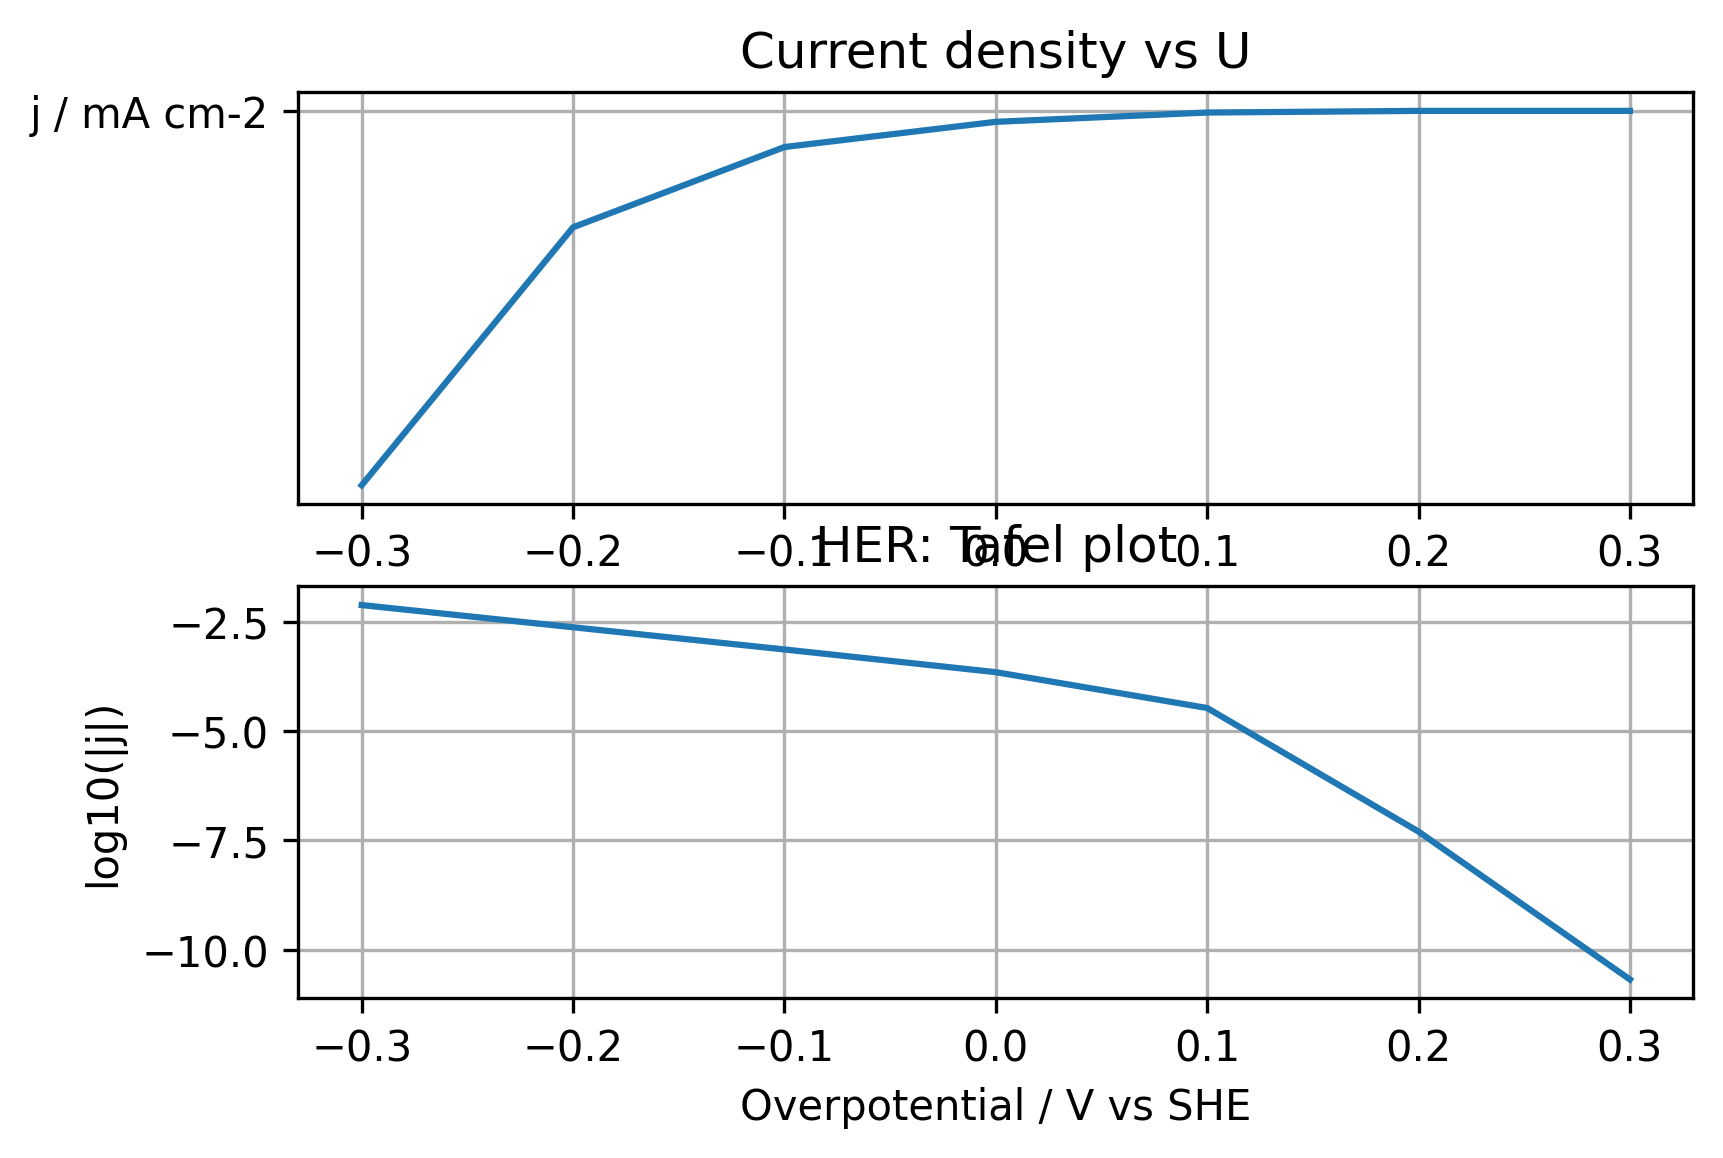

'Tafel slope = -5.073757535409045 V-1    alfa = 0.8697076664092412'

In [6]:
model.tafel_plot("HER", n ,7, jac=False)